# Goal

* Run `paco` analysis on IndD dataset summed by host
* Sensitivity analysis (species-level): selecting one sample per species
* Just Mammalia

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host phylogeny
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# misc
sparsity_cutoff = 0.05
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)
library(ape)
library(paco)

library(future)
library(future.batchtools)
library(future.apply)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘future.apply’

The following object is masked from ‘package:future’:

    future_lapply



In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/ 


In [4]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

# Load

In [5]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

In [6]:
physeq = physeq %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [7]:
host_tree = read.tree(host_tree_file)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	Node1, Node2, Node3, Node4, Node5, Node6, ...

Rooted; includes branch lengths.

# Filtering dataset

## Just Mammalia

In [9]:
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame 
metadata$SampleID = rownames(metadata)
metadata %>% dim %>% print

metadata_f = metadata %>%
    filter(class != 'Mammalia') %>% 
    dplyr::select(scientific_name, class, order, family, genus)

metadata = metadata %>%
    filter(class == 'Mammalia')

metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 172
[1] 160 172


X.SampleID,BarcodeSequence,LinkerPrimerSequence,Primer,ReversePrimer,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,⋯,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description,SampleID
X1.Eurasian.Beaver,ACTCACGGTATG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0049,1,1,Biber,Eurasian.Beaver,⋯,4,120,18,18,NA,1,20,1,NA,X1.Eurasian.Beaver
X101.Horse,ACGACGTCTTAG,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0030,101,101,Hauspferd,Horse,⋯,16,344,160,160,NA,2,20,101,NA,X101.Horse
X102.Kulan,ACGAGTGCTATC,CATGCTGCCTCCCGTAGGAGT,GCCTCCCTCGCGCCATCAG,AGAGTTTGATCCTGGCTCAG,338R_BC0031,102,102,Khulan,Kulan,⋯,16,345,161,161,NA,2,20,102,NA,X102.Kulan


In [10]:
# taxa to be removed
metadata_f %>% nrow %>% print
metadata_f

[1] 53


scientific_name,class,order,family,genus
Falco_tinnunculus,Aves,Falconiformes,Falconidae,Falco
Ardea_cinerea,Aves,Ciconiiformes,Ardeidae,Ardea
Haliaeetus_albicilla,Aves,Falconiformes,Accipitridae,Haliaeetus
Phalacrocorax_carbo,Aves,Pelecaniformes,Phalacrocoracidae,Phalacrocorax
Carduelis_chloris,Aves,Passeriformes,Fringillidae,Carduelis
Carduelis_chloris,Aves,Passeriformes,Fringillidae,Carduelis
Salvelinus_fontinalis,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus
Hemidactylus_frenatus,Reptilia,Squamata,Gekkonidae,Hemidactylus
Zamenis_longissimus,Reptilia,Squamata,Colubridae,Zamenis
Podarcis_siculus,Reptilia,Squamata,Lacertidae,Podarcis


In [11]:
# subsetting physeq
physeq = subset_samples(physeq, sample_names(physeq) %in% metadata$SampleID)

physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 160 samples ]
sample_data() Sample Data:       [ 160 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

## OTU table

In [12]:
physeq %>%
    otu_table %>% 
    colSums %>%
    summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   172.5  1089.5  1407.0  2469.0  4995.0 

In [13]:
metadata = physeq %>%
    sample_data %>%
    dplyr::select(scientific_name) %>%
    mutate(SampleID = rownames(.)) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
#metadata$sample = NULL

metadata %>% dfhead

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

[1] 160   2


,scientific_name,SampleID
X1.Eurasian.Beaver,Castor_fiber,X1.Eurasian.Beaver
X101.Horse,Equus_caballus,X101.Horse
X102.Kulan,Equus_hemionus,X102.Kulan


# Subsampling tree

* multiple subsamples: one sample per species

In [14]:
# number of subsampled trees
ntrees = 100

In [15]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    #tree$tip.label %>% length %>% print
    return(tree)
}

In [16]:
df = metadata %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:ntrees), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

# paco: diffused model

* on each subsample

## Creating datasets

In [17]:
make_paco_input = function(host_tree, physeq){
    # subsampled phyloseq object
    physeq_f = prune_samples(sample_names(physeq) %in% host_tree$tip.label, 
                             physeq) 

    # microbial distance matrix
    micro_D = physeq_f %>%
        phy_tree %>% cophenetic %>% 
        rescale_dist_mtx %>% as.matrix
    # host distance matrix
    host_D = host_tree %>% cophenetic %>% 
             rescale_dist_mtx %>% as.matrix
    
    # otu abundance matrix
    otu = physeq_f %>% 
        otu_table %>%
        as.data.frame %>%
        as.matrix %>%
        t %>%
        apply(2, function(x) ifelse(x > 0, 1, 0)) %>% as.matrix                
              
              
    # checking overlap
    x = length(intersect(rownames(otu), rownames(host_D)))
    y = length(union(rownames(otu), rownames(host_D)))
    stopifnot(x == y)
              
    # preparing paco data
    D = prepare_paco_data(H=host_D, P=micro_D, HP=otu)
    D = add_pcoord(D, correction='cailliez')
    return(D)
}

In [18]:
doParallel::registerDoParallel(threads)
paco_l = plyr::llply(host_tree_l, make_paco_input, physeq=physeq, .parallel=TRUE)
paco_l %>% length

[1] 100

## Running paco

In [19]:
# for loading results instead of re-running
PACo_file = file.path(work_dir, 'physeq_IndD-sens-justMam_PACo.RDS')
PACo_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-justMam_PACo.RDS"

In [21]:
# cluster resources
resources = list(h_rt = '24:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [22]:
# Running paco on each subsample
## WARNING: SLOW!
paco_each = function(D, nperm=99, seed=3843){
    PACo(D, nperm=nperm, seed=seed, method='quasiswap', symmetric=TRUE)
}

paco_res_l = future_lapply(paco_l, paco_each, nperm=999, future.packages=c('paco'))
paco_res_l %>% length

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

[1] 100

In [23]:
# save results
saveRDS(paco_res_l, PACo_file)
cat('File written:', PACo_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-justMam_PACo.RDS 


In [20]:
# load results
paco_res_l = readRDS(PACo_file)
paco_res_l %>% length

[1] 100

In [25]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/6a_paco_IndD_sensitivity-species-noArtiodactyla.ipynb')

## Formatting output

In [21]:
# goodness of fit
gof = lapply(paco_res_l, function(x) as.vector(x$gof)) %>% 
        do.call(rbind, .) %>%
        as.data.frame
             
gof$p %>% as.Num %>% summary %>% print
gof$ss %>% as.Num %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9812  0.9833  0.9837  0.9838  0.9845  0.9859 


In [27]:
# clearing memory; the `paco_res_l` object is huge
#paco_res_l = NULL

## Individual contributions

In [22]:
# for loading results instead of re-running
PACo_links_file = file.path(work_dir, 'physeq_IndD-sens-justMam_PACo-links.RDS')
PACo_links_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-justMam_PACo-links.RDS"

In [29]:
#-- WARNING: SLOW --#
# cluster resources
resources = list(h_rt = '36:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

# running
D_links_l = future_lapply(paco_res_l, paco_links, future.packages=c('paco'))
D_links_l %>% length

[1] 100

In [30]:
# saving object
saveRDS(D_links_l, PACo_links_file)
cat('File written:', PACo_links_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-justMam_PACo-links.RDS 


In [23]:
# re-loading object
D_links_l = readRDS(PACo_links_file)
D_links_l %>% length

[1] 100

In [24]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/6a_paco_IndD_sensitivity-species-noArtiodactyla.ipynb')

### Formatting output

In [25]:
# residuals
get_residuals = function(rep, D_links_l){
    # residuals
    res = residuals_paco(D_links_l[[rep]]$proc) %>% as.data.frame 
    colnames(res) = 'residuals'
    res = res %>%
        mutate(comparison = rownames(.),
               subsample_rep = rep) %>%
        separate(comparison, c('host', 'microbe'), sep='-') 
        
    # jackknife
    D_links_jk = do.call(rbind, D_links_l[[rep]]$jackknife) %>%
        t %>% as.data.frame %>%
        mutate(comparison = rownames(.)) %>%
        separate(comparison, c('host', 'microbe'), sep='-') %>%
        inner_join(res, c('host'='host', 'microbe'='microbe'))
    
    # return
    return(D_links_jk)
}

D_links_l = lapply(as.list(1:length(D_links_l)), get_residuals, D_links_l=D_links_l)
D_links_l = do.call(rbind, D_links_l)
D_links_l %>% dfhead

[1] 219705      6


mean,upper,host,microbe,residuals,subsample_rep
-163.71339,-163.70317,X122.Wild.Boar,368bd5c2255f3a5ce0fef06ca6de1d04,0.01997950,1
-55.39473,-55.38612,X123.Alpine.Chamois,368bd5c2255f3a5ce0fef06ca6de1d04,0.01162143,1
-57.85786,-57.84983,X133.Domestic.Goat,368bd5c2255f3a5ce0fef06ca6de1d04,0.01187704,1


### Summarizing residuals

In [26]:
D_links_l = D_links_l %>%
    group_by(host, microbe) %>%
    summarize(mean_resid = mean(residuals),
              median_resid = median(residuals),
              sd_resid = sd(residuals),
              CV_resid = sd_resid / mean_resid * 100) %>%
    ungroup()

D_links_l %>% dfhead

[1] 5622    6


host,microbe,mean_resid,median_resid,sd_resid,CV_resid
F35.Red.Deer,01870326c8abb62d307cdd60c70a13ba,0.01012781,0.010165438,0.0002817210,2.781658
F35.Red.Deer,0206837371f48a70d8103167f4b4204f,0.01007918,0.010079688,0.0003120697,3.096181
F35.Red.Deer,045ca06e5f493a2f85cc8c1a31a0c78e,0.01011749,0.009982075,0.0003487025,3.446533


### Adding taxonomy

In [27]:
# adding taxonomy
tax = physeq %>% tax_table %>% 
    as.matrix %>% as.data.frame %>%
    mutate(microbe = rownames(.))

D_links_l = D_links_l %>%
    inner_join(tax, c('microbe'))

D_links_l %>% dfhead

[1] 5622   13


host,microbe,mean_resid,median_resid,sd_resid,CV_resid,Domain,Phylum,Class,Order,Family,Genus,Species
F35.Red.Deer,01870326c8abb62d307cdd60c70a13ba,0.01012781,0.010165438,0.0002817210,2.781658,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,uncultured bacterium
F35.Red.Deer,0206837371f48a70d8103167f4b4204f,0.01007918,0.010079688,0.0003120697,3.096181,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Pseudobutyrivibrio,unclassified
F35.Red.Deer,045ca06e5f493a2f85cc8c1a31a0c78e,0.01011749,0.009982075,0.0003487025,3.446533,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,uncultured Ruminococcaceae bacterium


In [28]:
# adding metadata
host_tax = physeq %>% sample_data %>% 
    as.matrix %>% as.data.frame %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, class, order, family, genus, scientific_name, diet)

D_links_l = D_links_l %>%
    inner_join(host_tax, c('host'='sample')) 

D_links_l %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 5622   19


host,microbe,mean_resid,median_resid,sd_resid,CV_resid,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,genus,scientific_name,diet
F35.Red.Deer,01870326c8abb62d307cdd60c70a13ba,0.01012781,0.010165438,0.0002817210,2.781658,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,uncultured bacterium,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore
F35.Red.Deer,0206837371f48a70d8103167f4b4204f,0.01007918,0.010079688,0.0003120697,3.096181,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Pseudobutyrivibrio,unclassified,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore
F35.Red.Deer,045ca06e5f493a2f85cc8c1a31a0c78e,0.01011749,0.009982075,0.0003487025,3.446533,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,uncultured Ruminococcaceae bacterium,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore


### Summarizing results

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-justMam_resid_mean-sd_diet.pdf 


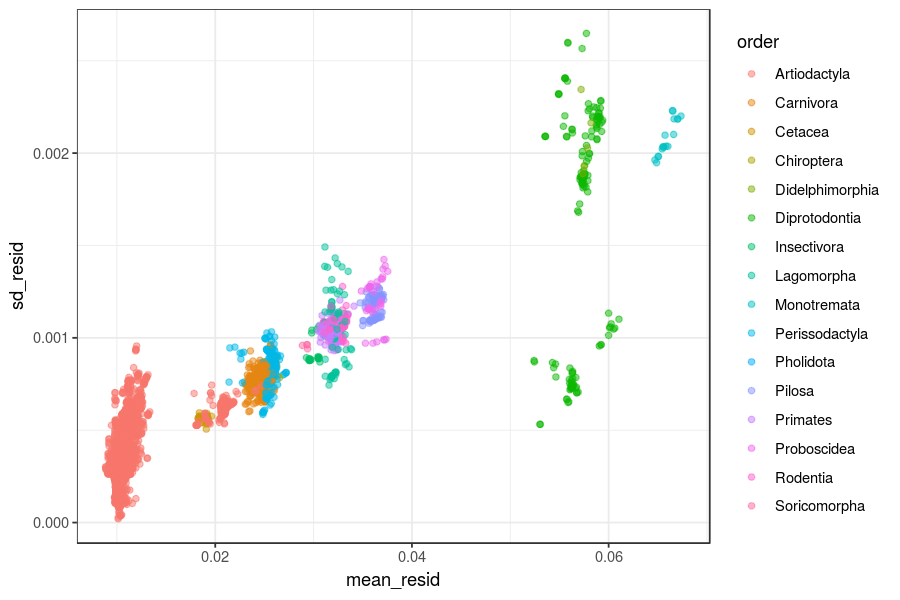

In [29]:
p = ggplot(D_links_l, aes(mean_resid, sd_resid, color=order)) +
    geom_point(alpha=0.5) +
    theme_bw() 

options(repr.plot.width=7.5, repr.plot.height=5)
plot_write(p, file='IndD_sens-justMam_resid_mean-sd_diet.pdf')

#### CV resulting from intra-species variance

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2018  2.7975  3.1061  3.2234  3.5627  7.9658 
File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-justMam_resid_histo.pdf 


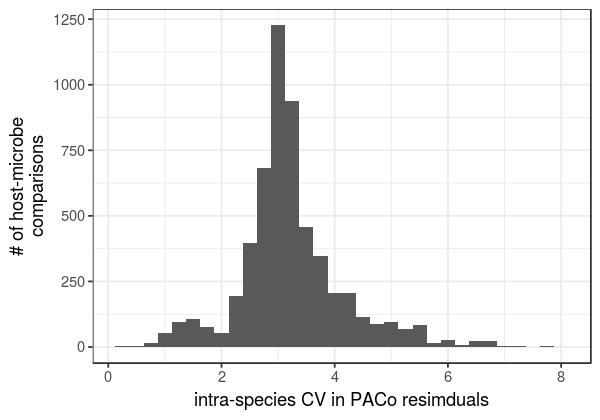

In [30]:
# CV variance due to 
D_links_l$CV_resid %>% summary %>% print

p = ggplot(D_links_l, aes(CV_resid)) +
    geom_histogram(binwidth=0.25) +
    labs(x='intra-species CV in PACo resimduals', y='# of host-microbe\ncomparisons') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=3.5)
plot_write(p, 'IndD_sens-justMam_resid_histo.pdf')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2018  2.7975  3.1061  3.2234  3.5627  7.9658 


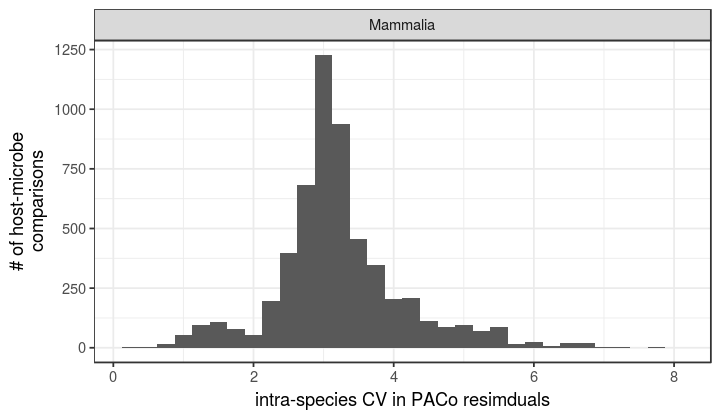

In [31]:
# CV variance due to 
D_links_l$CV_resid %>% summary %>% print

p = ggplot(D_links_l, aes(CV_resid)) +
    geom_histogram(binwidth=0.25) +
    labs(x='intra-species CV in PACo resimduals', y='# of host-microbe\ncomparisons') +
    facet_wrap(~ class, scales='free_y') +
    theme_bw()

options(repr.plot.width=6, repr.plot.height=3.5)
plot(p)

#### Notes

* a rather low intra-species CV, suggesting that intra-species variation doesn't affect residuals much

### Summing residuals by host data

In [32]:
D_links_l_s = D_links_l %>% 
    dplyr::select(host, microbe, mean_resid, diet, class) %>%
    gather(category, value, -host, -microbe, -mean_resid, -class) 

D_links_l_s %>% dfhead

[1] 5622    6


host,microbe,mean_resid,class,category,value
F35.Red.Deer,01870326c8abb62d307cdd60c70a13ba,0.01012781,Mammalia,diet,herbivore
F35.Red.Deer,0206837371f48a70d8103167f4b4204f,0.01007918,Mammalia,diet,herbivore
F35.Red.Deer,045ca06e5f493a2f85cc8c1a31a0c78e,0.01011749,Mammalia,diet,herbivore


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-justMam_resid_diet.pdf 


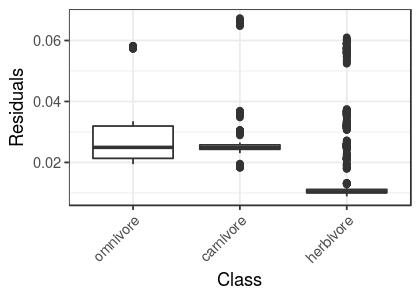

In [33]:
tmp = D_links_l %>% 
    group_by(diet) %>%
    mutate(median_resid = median(mean_resid)) %>%
    ungroup() %>%
    mutate(diet = diet %>% reorder(-median_resid))

p = ggplot(tmp, aes(diet, mean_resid)) +
    geom_boxplot() +
    labs(x='Class', y='Residuals') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=3.5, repr.plot.height=2.5)
plot_write(p, file='IndD_sens-justMam_resid_diet.pdf')

In [34]:
# anova
aov_res = aov(mean_resid ~ diet, data=D_links_l)
aov_res %>% summary

              Df Sum Sq Mean Sq F value Pr(>F)    
diet           2 0.1151 0.05757   619.1 <2e-16 ***
Residuals   5619 0.5226 0.00009                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-justMam_resid_order.pdf 


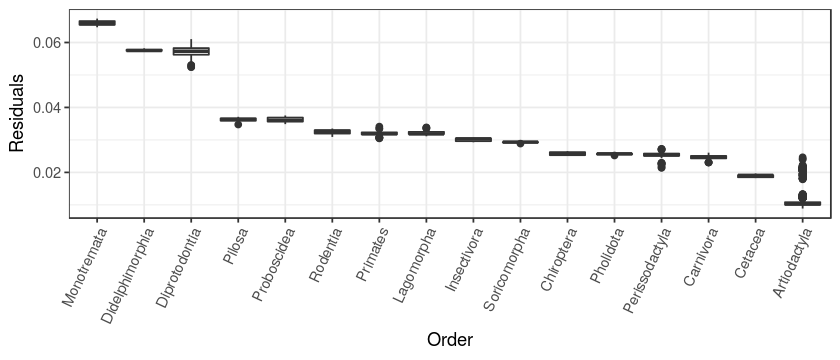

In [37]:
# by order
tmp = D_links_l %>% 
    group_by(order) %>%
    mutate(median_resid = median(mean_resid)) %>%
    ungroup() %>%
    group_by(class) %>%
    mutate(median_resid_class = median(mean_resid)) %>%
    ungroup() %>%   
    mutate(order = order %>% reorder(-median_resid))

p = ggplot(tmp, aes(order, mean_resid)) +
    geom_boxplot() +
    labs(x='Order', y='Residuals') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=65, hjust=1)
    )

options(repr.plot.width=7, repr.plot.height=3)
plot_write(p, file='IndD_sens-justMam_resid_order.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-justMam_resid_family.pdf 


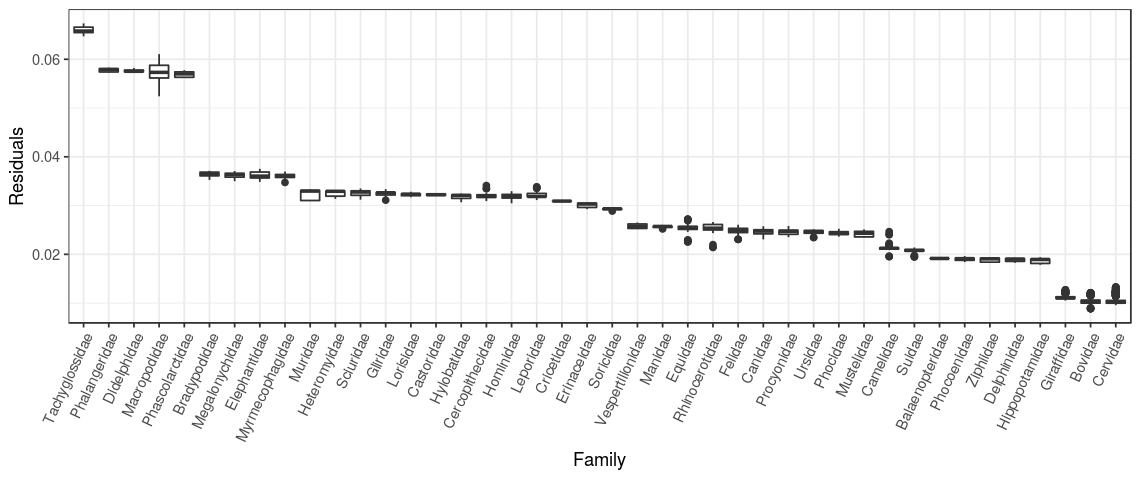

In [90]:
# by family
tmp = D_links_l %>% 
    group_by(family) %>%
    mutate(median_resid = median(mean_resid)) %>%
    ungroup() %>%
    group_by(class) %>%
    mutate(median_resid_class = median(mean_resid)) %>%
    ungroup() %>%   
    mutate(family = family %>% reorder(-median_resid))

p = ggplot(tmp, aes(family, mean_resid)) +
    geom_boxplot() +
    labs(x='Family', y='Residuals') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=65, hjust=1)
    )

options(repr.plot.width=9.5, repr.plot.height=4)
plot_write(p, file='IndD_sens-justMam_resid_family.pdf')

### Regressing out diet

In [91]:
x = lm(mean_resid ~ diet, data=D_links_l)
D_links_l$phy_resid = x$residuals %>% scales::rescale(to=c(0,1))
D_links_l %>% status

[1] 5622   20


host,microbe,mean_resid,median_resid,sd_resid,CV_resid,Domain,Phylum,Class,Order,Family,Genus,Species,class,order,family,genus,scientific_name,diet,phy_resid
F35.Red.Deer,01870326c8abb62d307cdd60c70a13ba,0.01012781,0.010165438,0.0002817210,2.781658,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,uncultured,uncultured bacterium,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,0.09854501
F35.Red.Deer,0206837371f48a70d8103167f4b4204f,0.01007918,0.010079688,0.0003120697,3.096181,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Pseudobutyrivibrio,unclassified,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,0.09768411
F35.Red.Deer,045ca06e5f493a2f85cc8c1a31a0c78e,0.01011749,0.009982075,0.0003487025,3.446533,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,uncultured Ruminococcaceae bacterium,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus_elaphus,herbivore,0.09836220


File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.figures/IndD_sens-justMam_phy-resid_family.pdf 


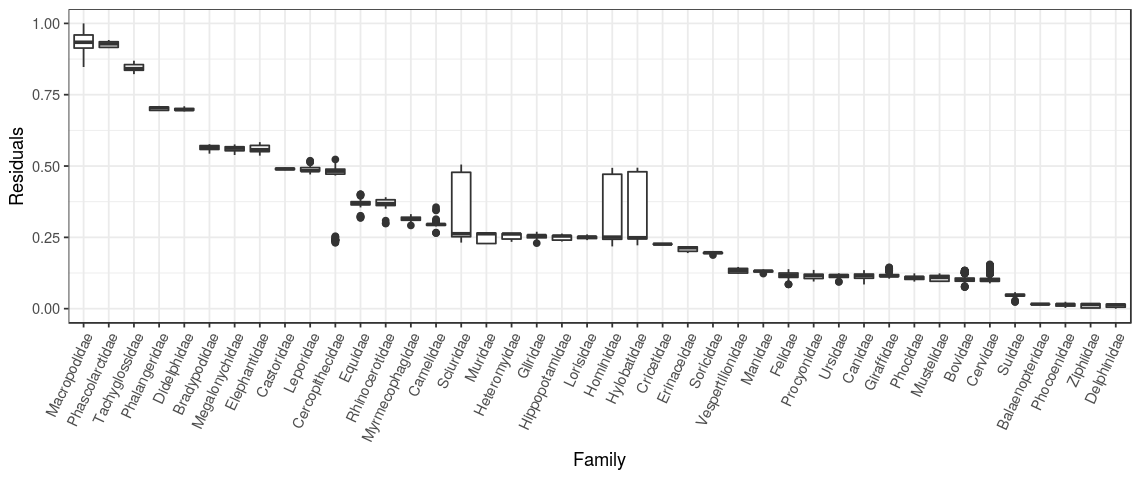

In [92]:
tmp = D_links_l %>% 
    group_by(family) %>%
    mutate(median_resid = median(phy_resid)) %>%
    ungroup() %>%
    group_by(class) %>%
    mutate(median_resid_class = median(phy_resid)) %>%
    ungroup() %>%   
    mutate(family = family %>% reorder(-median_resid))

p = ggplot(tmp, aes(family, phy_resid)) +
    geom_boxplot() +
    labs(x='Family', y='Residuals') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=65, hjust=1)
    )

options(repr.plot.width=9.5, repr.plot.height=4)
plot_write(p, file='IndD_sens-justMam_phy-resid_family.pdf')

### Formatting for iTOL

In [95]:
otu_m = D_links_l %>%
    mutate(host = gsub(' ', '_', scientific_name)) %>%
    group_by(host, Genus, microbe) %>%
    #summarize(mean_resid = mean(phy_resid, na.rm=TRUE)) %>%
    summarize(mean_resid = mean(mean_resid, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(microbe = microbe %>% as.factor %>% as.numeric,
           microbe = gsub('^', 'SV', microbe)) %>%
    unite(OTU, Genus, microbe) %>%
    filter(!grepl('^_SV', OTU)) %>%
    dplyr::select(host, OTU, mean_resid) %>%
    spread(OTU, mean_resid) %>%
    as.data.frame

rownames(otu_m) = otu_m$host 
otu_m$host = NULL
rownames(otu_m) = gsub('^X', '', rownames(otu_m))

otu_m %>% status

[1]  82 381


,Acinetobacter_SV154,Acinetobacter_SV156,Akkermansia_SV184,Alistipes_SV10,Alistipes_SV13,Alistipes_SV143,Alistipes_SV157,Alistipes_SV162,Alistipes_SV163,Alistipes_SV189,⋯,uncultured_SV80,uncultured_SV83,uncultured_SV84,uncultured_SV86,uncultured_SV87,uncultured_SV88,uncultured_SV91,uncultured_SV93,uncultured_SV97,uncultured_SV99
Aepyceros_melampus,NA,NA,NA,NA,NA,0.01113751,NA,NA,NA,NA,⋯,NA,NA,0.01028743,NA,0.01065991,NA,NA,0.01020812,NA,NA
Apodemus_flavicollis,NA,NA,NA,NA,NA,NA,NA,NA,0.03331647,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Apodemus_sylvaticus,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [96]:
# checking overlap with host clado tips
#host_tree = read.tree(host_tree_file)
#setdiff(host_tree$tip.label, rownames(otu_m)) %>% print
#setdiff(rownames(otu_m), host_tree$tip.label) %>% print

In [97]:
itol_htmp_file = file.path(work_dir, 'physeq_IndD-sens-justMam_PACo-Con-links_htmp.txt')
labs = gsub(' ', '_', colnames(otu_m))
labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

cat('DATASET_HEATMAP\n', file=itol_htmp_file)
cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
cat('DATASET_LABEL paco_residuals\n', file=itol_htmp_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
cat(labs, file=itol_htmp_file, append=TRUE)
cat('DATA\n', file=itol_htmp_file, append=TRUE)
write.table(otu_m, file=itol_htmp_file, append=TRUE, sep=' ', 
            quote=FALSE, col.names=FALSE)
cat('File written:', itol_htmp_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-justMam_PACo-Con-links_htmp.txt 


#### iTOL: distribution of residuals per host species

In [98]:
# summing residuals by host
#ID1,minimum,q1,median,q3,maximum,extreme_value1,extreme_value2
tmp = D_links_l %>%
    #mutate(mean_resid = phy_resid) %>%    # diet regressed out
    filter(!is.na(mean_resid)) %>%
    mutate(host = gsub(' ', '_', scientific_name)) %>%
    group_by(host, Genus, microbe) %>%
    summarize(mean_resid = mean(mean_resid, na.rm=TRUE)) %>%
    ungroup() %>%
    group_by(host) %>%
    summarize(minimum = min(mean_resid),
              q1 = quantile(mean_resid, 0.25),
              median = median(mean_resid),
              q3 = quantile(mean_resid, 0.75),
              maximum = max(mean_resid)) %>%
    ungroup() 


tmp %>% status

[1] 82  6


host,minimum,q1,median,q3,maximum
Aepyceros_melampus,0.01002696,0.01026847,0.01041608,0.01071294,0.01181609
Apodemus_flavicollis,0.03103510,0.03299206,0.03308623,0.03315675,0.03331647
Apodemus_sylvaticus,0.03103441,0.03149439,0.03195437,0.03241435,0.03287433


In [99]:
itol_box_file = file.path(work_dir, 'physeq_IndD-sens-justMam_PACo-Con-links_box.txt')

cat('DATASET_BOXPLOT\n', file=itol_box_file)
cat('SEPARATOR SPACE\n', file=itol_box_file, append=TRUE)
cat('DATASET_LABEL paco_resid_justMam\n', file=itol_box_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_box_file, append=TRUE)
cat('DATA\n', file=itol_box_file, append=TRUE)
write.table(tmp, file=itol_box_file, append=TRUE, sep=' ', 
            quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('File written:', itol_box_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD-sens-justMam_PACo-Con-links_box.txt 


# sessionInfo

In [74]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2            future.apply_1.0.0      future.batchtools_0.7.0
 [4] future_1.8.1            paco_0.3.2              ape_5.1                
 [7] phyloseq_1.22.3         stringr_1.2.0    